In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    !pip install livelossplot
print(torchbearer.__version__)

     |████████████████████████████████| 138 kB 14.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
0.5.3


In [ ]:
import os
os.listdir('/content/drive/MyDrive/ANN-HW4/Linnaeus5/train')

['berry', 'bird', 'dog', 'flower', 'other']

In [ ]:
pic_selected = sorted(os.listdir("/content/drive/MyDrive/ANN-HW4/Linnaeus5/train"))
pic_selected

['berry', 'bird', 'dog', 'flower', 'other']

In [ ]:
data_dir="/content/drive/MyDrive/ANN-HW4/Linnaeus5/train"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

rows = 1
cols = 5
counter=0
data=[]
label=[]
for pic_id in pic_selected:
  counter=pic_selected.index(pic_id)
  pic_selected_images = os.listdir(os.path.join(data_dir,pic_id))
  for id in pic_selected_images:
    data.append(plt.imread(os.path.join(data_dir,pic_id, id)))
    label.append(counter)

    

In [ ]:
dataset=np.array(data)
labels=np.array(label)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_eval, y_train, y_eval = train_test_split(dataset, labels, test_size=0.2, random_state=1)

In [ ]:
X_train=X_train/256
X_eval=X_eval/256

In [ ]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes=5)
y_eval = to_categorical(y_eval, num_classes=5)

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, Input, BatchNormalization, Add, LeakyReLU, GlobalMaxPooling2D
from keras.regularizers import l1_l2

inp=Input(shape=(128,128,3), name="Input")
y=inp
x=Conv2D(128,kernel_size=2,strides=1,padding='same')(inp)
x=BatchNormalization()(x)
x=MaxPooling2D(pool_size=(2, 2))(x)
x = LeakyReLU(alpha=0.02)(x)
x=Dropout(0.2)(x)

x=Conv2D(128,kernel_size=2,strides=1, padding='same')(x)
x=BatchNormalization()(x)
x=MaxPooling2D(pool_size=(2, 2))(x)
x = LeakyReLU(alpha=0.02)(x)
x=Dropout(0.2)(x)

x=Conv2D(128,kernel_size=1,strides=1, padding='same')(x)
x=BatchNormalization()(x)

skip=Conv2D(128,kernel_size=3,strides=1, padding='same')(inp)
skip=MaxPooling2D(pool_size=(4, 4))(skip)
x=Add()([x,skip])
x = LeakyReLU(alpha=0.02)(x)

x=GlobalMaxPooling2D()(x)
x=Dense(128,activation="relu")(x)
x=Dropout(0.2)(x)
Output=Dense(5,activation="softmax")(x)

model = Model(inputs=inp, outputs=Output, name='ResNet')

In [ ]:
model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 128, 128, 12  1664        ['Input[0][0]']                  
                                8)                                                                
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 128, 12  512        ['conv2d_4[0][0]']               
 rmalization)                   8)                                                           

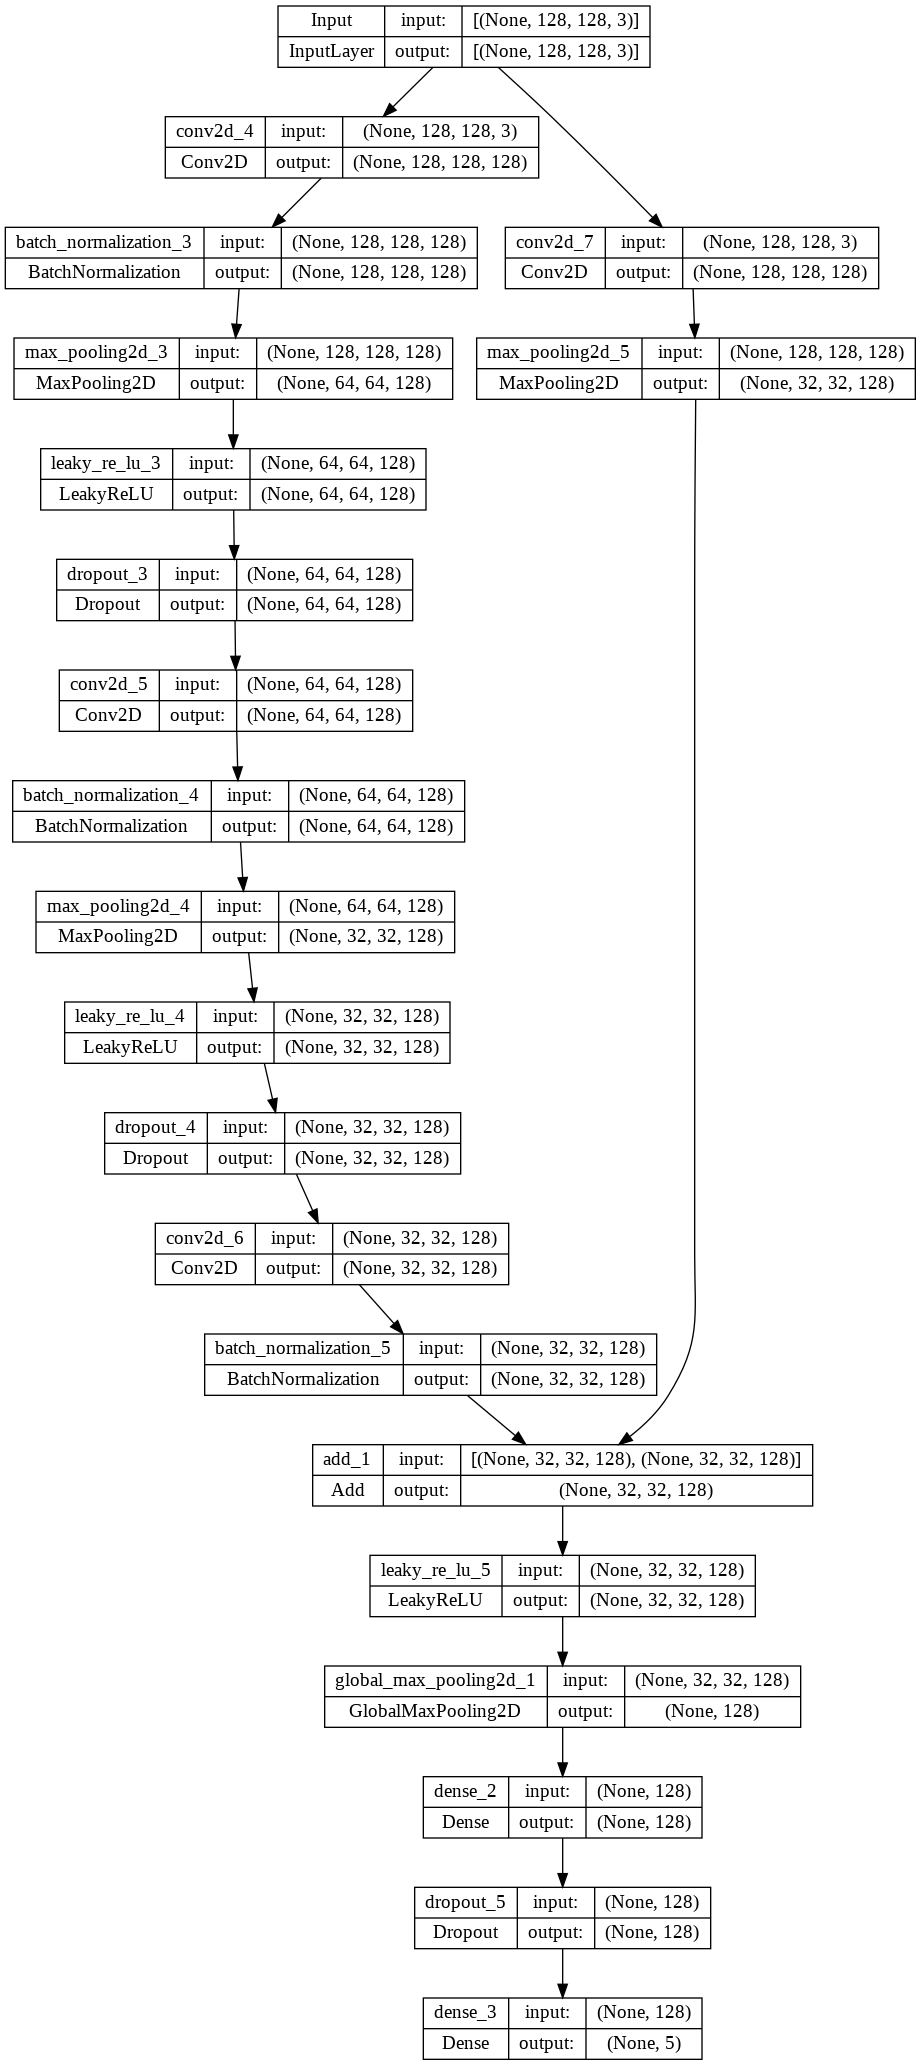

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

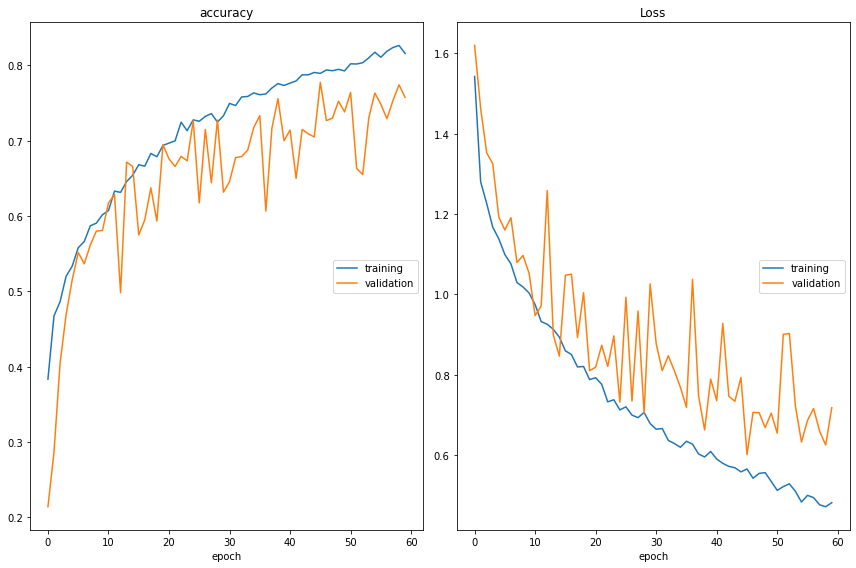

accuracy
	training         	 (min:    0.384, max:    0.826, cur:    0.816)
	validation       	 (min:    0.214, max:    0.777, cur:    0.757)
Loss
	training         	 (min:    0.472, max:    1.542, cur:    0.482)
	validation       	 (min:    0.601, max:    1.620, cur:    0.718)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from livelossplot import PlotLossesKeras

n_epochs = 60

#optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=20,
                           restore_best_weights=True,
                           mode='min')

# tensorboard_callback = TensorBoard(log_dir="./logs")

# Actual fitting of the model
history = model.fit(X_train, y_train,batch_size=20,shuffle=True,
                    epochs=n_epochs, 
                    validation_data=(X_eval,y_eval),
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

In [ ]:
model.save('ResNet1.h5')